In [1]:
import pandas as pd
import os
import numpy as np

# Cleaning
import re
import emoji
import string
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split
seed_value = 42

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#Logistic regression
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression #Prediction Model
from sklearn.metrics import accuracy_score #Comparison between real and predicted

#Random Forest
from sklearn.ensemble import RandomForestClassifier

#SVM
from sklearn.svm import SVC

# Skip, data merging

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [3]:
os.getcwd()

'C:\\Users\\mamai\\Desktop\\Tesi\\Code\\notebookFinaliprove'

In [6]:
def merge_csv(input1, input2, input3, input4):
    path = 'C:\\Users\\mamai\\Desktop\\Tesi\\Code\\twitter download\\'
    path1 = path + input1
    path2 = path + input2
    path3 = path + input3
    path4 = path + input4
    data1 = pd.read_csv(path1)
    data2 = pd.read_csv(path2)
    data3 = pd.read_csv(path3)
    data4 = pd.read_csv(path4)
    output_data = pd.concat([data1,data2,data3,data4])
    output_data.reset_index(inplace=True, drop=True)
    return output_data

In [7]:
data = merge_csv('data_5000.csv', 'data_10000.csv', 'data_from_15000_to_50000.csv', 'data_from_50000_to_130000.csv')
data = data.drop(data.columns[0], axis=1).reset_index(drop=True)
data.head()

,ID,text,sentiment
0,1629275091325583362,"RT @PoliticalMoons2: These two recent articles discuss H5N1 ""bird flu"" in detail; the first delineating an accurate 8-month old projection…",0.18750
1,1629275093242351617,RT @hotpriestt: eat her pussy👀,0.00000
2,1629275094294884352,RT @hcasan0va: These people have lost their minds. Just bc there’s a global org with a perspective doesn’t mean we have to comply. This wil…,-0.15625
3,1629275094735372289,"RT @VigilantFox: Shedding Concerns: ""It Looks Like the mRNA is Transferring from the Vaccinated to the Unvaccinated""\n\nCould you actually ta…",0.00000
4,1629275094445969408,@LeslynLewis @AirCanada Wear a mask then.,0.00000


In [8]:
# Cleaning

In [9]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#clean retweet symbol
def clean_retweet(text):
    text = text.replace("rt ", "")
    return text

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
#NOTE:Stemming seems to work better for this dataset
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def deep_clean(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = clean_retweet(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [10]:
texts_new = []
for t in data.text:
    texts_new.append(deep_clean(t))

C:\Users\mamai\AppData\Local\Temp/ipykernel_30228/4024386252.py:5: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji


In [11]:
data['text_cleaned'] = texts_new

In [12]:
data.head()

,ID,text,sentiment,text_cleaned
0,1629275091325583362,"RT @PoliticalMoons2: These two recent articles discuss H5N1 ""bird flu"" in detail; the first delineating an accurate 8-month old projection…",0.18750,two recent articl discuss h5n1 bird flu detail first delin accur 8month old project
1,1629275093242351617,RT @hotpriestt: eat her pussy👀,0.00000,eat pussi
2,1629275094294884352,RT @hcasan0va: These people have lost their minds. Just bc there’s a global org with a perspective doesn’t mean we have to comply. This wil…,-0.15625,peopl lost mind bc there global org perspect doesnt mean compli wil
3,1629275094735372289,"RT @VigilantFox: Shedding Concerns: ""It Looks Like the mRNA is Transferring from the Vaccinated to the Unvaccinated""\n\nCould you actually ta…",0.00000,shed concern look like mrna transfer vaccin unvaccin could actual ta
4,1629275094445969408,@LeslynLewis @AirCanada Wear a mask then.,0.00000,wear mask


In [13]:
# Text length analysis

In [15]:
text_len = []
for text in data.text_cleaned:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [16]:
data['text_len'] = text_len

In [17]:
data.head()

,ID,text,sentiment,text_cleaned,text_len
0,1629275091325583362,"RT @PoliticalMoons2: These two recent articles discuss H5N1 ""bird flu"" in detail; the first delineating an accurate 8-month old projection…",0.18750,two recent articl discuss h5n1 bird flu detail first delin accur 8month old project,14
1,1629275093242351617,RT @hotpriestt: eat her pussy👀,0.00000,eat pussi,2
2,1629275094294884352,RT @hcasan0va: These people have lost their minds. Just bc there’s a global org with a perspective doesn’t mean we have to comply. This wil…,-0.15625,peopl lost mind bc there global org perspect doesnt mean compli wil,12
3,1629275094735372289,"RT @VigilantFox: Shedding Concerns: ""It Looks Like the mRNA is Transferring from the Vaccinated to the Unvaccinated""\n\nCould you actually ta…",0.00000,shed concern look like mrna transfer vaccin unvaccin could actual ta,11
4,1629275094445969408,@LeslynLewis @AirCanada Wear a mask then.,0.00000,wear mask,2


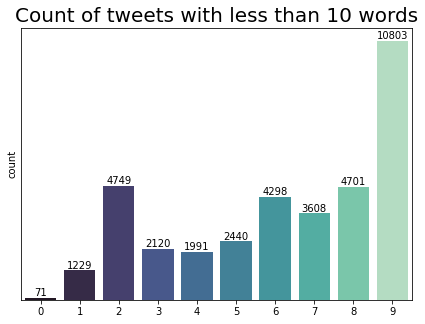

In [18]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=data[data['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [19]:
data = data[data['text_len'] > 3]

In [20]:
#data.sort_values(by=['text_len'], ascending=False)

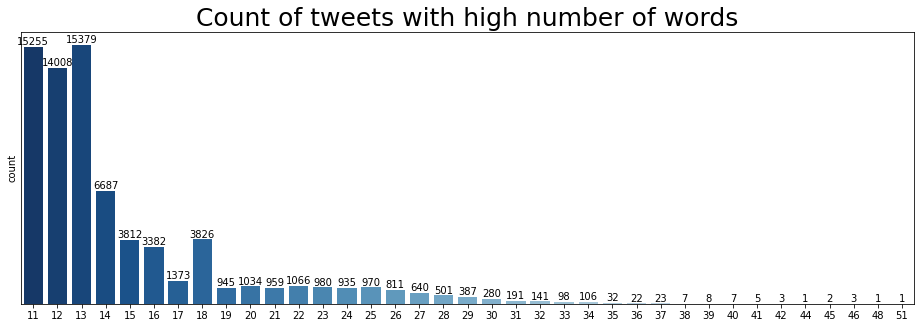

In [21]:

plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=data[(data['text_len']<=1000) & (data['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [22]:
max_len = np.max(data['text_len'])
max_len 

51

In [23]:
len(data)

111047

In [24]:
data.to_csv('merged_len_and_cleaned_130000.csv')

# Categoric labels

Ha senso farne 3 perchè tanto di tweet molto positivi o molto negativi ne avrei pochi comunque

In [9]:
labels = []
for sent in data.sentiment:
    if sent == 0:
        label = '0'
    elif sent > 0 and sent <= 1:
        label = '1'
    elif sent >= -1 and sent <0:
        label = '-1'
    labels.append(label)

In [10]:
data['labels'] = labels
data.head()

,ID,text,sentiment,text_cleaned,text_len,labels
0,1629275091325583362,RT @PoliticalMoons2: These two recent articles...,0.18750,two recent articl discuss h5n1 bird flu detail...,14,1
2,1629275094294884352,RT @hcasan0va: These people have lost their mi...,-0.15625,peopl lost mind bc there global org perspect d...,12,-1
3,1629275094735372289,"RT @VigilantFox: Shedding Concerns: ""It Looks ...",0.00000,shed concern look like mrna transfer vaccin un...,11,0
5,1629275098308902912,"RT @VigilantFox: Ed Dowd: ""This Has Been a War...",0.10000,ed dowd war peopl die covid vaccin death earli...,12,1
6,1629275098451509250,RT @porta_janet: @VigilantFox @DrKStillwagon T...,0.00000,vaccin brought covid covid brought vaccin,6,0


# Machine Learning models

In [2]:
data = pd.read_csv('C:\\Users\\mamai\\Desktop\\Tesi\\Code\\BERT\\bert_tweets_130000.csv')
data.head()

,ID,text,sentiment,text_cleaned,text_len,labels,text_bert,text_len_bert
0,1629275091325583362,RT @PoliticalMoons2: These two recent articles...,0.18750,two recent articl discuss h5n1 bird flu detail...,14,1,"RT These two recent articles discuss H5N1 ""bir...",19
1,1629275094294884352,RT @hcasan0va: These people have lost their mi...,-0.15625,peopl lost mind bc there global org perspect d...,12,-1,RT These people have lost their minds. Just bc...,24
2,1629275094735372289,"RT @VigilantFox: Shedding Concerns: ""It Looks ...",0.00000,shed concern look like mrna transfer vaccin un...,11,0,"RT Shedding Concerns: ""It Looks Like the mRNA ...",20
3,1629275098308902912,"RT @VigilantFox: Ed Dowd: ""This Has Been a War...",0.10000,ed dowd war peopl die covid vaccin death earli...,12,1,"RT Ed Dowd: ""This Has Been a War"" ""The people ...",23
4,1629275098451509250,RT @porta_janet: @VigilantFox @DrKStillwagon T...,0.00000,vaccin brought covid covid brought vaccin,6,0,RT The vaccine was not brought in for Covid… C...,17


In [3]:
max_len=np.max(data.text_len)
max_len

51

In [4]:
X = data['text_cleaned']
y = data['labels']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [7]:
X_train.head()

353      child labor back doubt gain accept way around ...
55216    like use realli gaf ppl thought ugli kinda sto...
53129            guess could vaccin next go sure seem care
15324    social media user fals claim maker covid19 vac...
53862                          covid thing care bit anymor
Name: text_cleaned, dtype: object

In [8]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [9]:
#sparse matrix, ogni colonna è una parola e ogni riga un tweet, nei valuea abbiamo quante volte compare la parola nl tweet

In [10]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [11]:
# sparse matrix (dovrebbe essere riaggiustata con la frequenza delle parole o boh)

# Naive Bayes

In [12]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [13]:
nb_pred = nb_clf.predict(X_test_tf)
nb_pred

array([ 1,  0, -1, ...,  1,  1,  1], dtype=int64)

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

          -1       0.90      0.73      0.81      6447
           0       0.90      0.76      0.82      7206
           1       0.74      0.94      0.83      8557

    accuracy                           0.82     22210
   macro avg       0.85      0.81      0.82     22210
weighted avg       0.84      0.82      0.82     22210



In [15]:
conf = confusion_matrix(y_test,nb_pred)
print(conf)

[[4723  329 1395]
 [ 294 5489 1423]
 [ 218  313 8026]]


In [16]:
conf_df = pd.DataFrame(data=conf, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'], 
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

<AxesSubplot:>

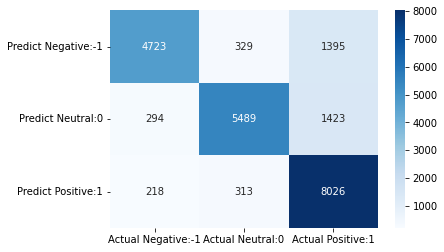

In [17]:
sns.heatmap(conf_df, annot = True, fmt = '', cmap = 'Blues')

In [18]:
#y_test

In [19]:
import collections
c = collections.Counter(y_test)
print(c)

Counter({1: 8557, 0: 7206, -1: 6447})


# Logistic regression

In [20]:
#Initial Bag of Words
bow_counts = CountVectorizer(
    tokenizer=word_tokenize
)
X_train_bow =  bow_counts.fit_transform(X_train)
X_test_bow = bow_counts.transform(X_test)

In [21]:
y_train_bow = y_train
y_test_bow = y_test

In [22]:
# Logistic regression
model1 = LogisticRegression(C=1, solver="liblinear",max_iter=200)
model1.fit(X_train_bow, y_train_bow)
# Prediction
test_pred = model1.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow, test_pred) * 100)

Accuracy:  92.96713192255741


In [23]:
print('Classification Report for Logistic Regression:\n',classification_report(y_test, test_pred))

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

          -1       0.93      0.90      0.92      6447
           0       0.92      0.96      0.94      7206
           1       0.94      0.93      0.93      8557

    accuracy                           0.93     22210
   macro avg       0.93      0.93      0.93     22210
weighted avg       0.93      0.93      0.93     22210



In [24]:
conf_log = confusion_matrix(y_test,test_pred)
print(conf_log)

[[5817  304  326]
 [ 143 6883  180]
 [ 306  303 7948]]


In [25]:
conf_df_log = pd.DataFrame(data=conf_log, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'], 
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

<AxesSubplot:>

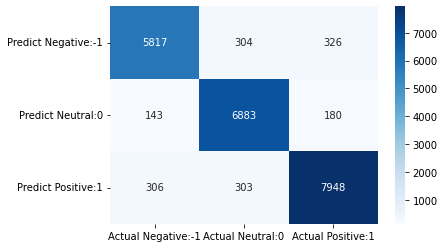

In [26]:
sns.heatmap(conf_df_log, annot = True, fmt = '', cmap = 'Blues')

# Random Forest

In [27]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_tf,y_train)

RandomForestClassifier()

In [28]:
rf_pred = rf_clf.predict(X_test_tf)
rf_pred

array([ 0,  0, -1, ...,  1,  1,  0], dtype=int64)

In [29]:
print('Classification Report for Random Forest:\n',classification_report(y_test, rf_pred))

Classification Report for Random Forest:
               precision    recall  f1-score   support

          -1       0.96      0.87      0.91      6447
           0       0.90      0.97      0.94      7206
           1       0.93      0.93      0.93      8557

    accuracy                           0.93     22210
   macro avg       0.93      0.93      0.93     22210
weighted avg       0.93      0.93      0.93     22210



In [30]:
conf_rf = confusion_matrix(y_test,rf_pred)
print(conf_rf)

[[5611  362  474]
 [  46 7009  151]
 [ 190  378 7989]]


In [31]:
conf_df_rf = pd.DataFrame(data=conf_rf, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'], 
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

<AxesSubplot:>

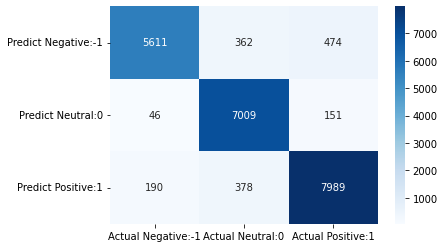

In [32]:
sns.heatmap(conf_df_rf, annot = True, fmt = '', cmap = 'Blues')

# SVM

In [33]:
#long time to train!

In [34]:
svm_clf=SVC()
svm_clf.fit(X_train_tf,y_train)

SVC()

In [35]:
svm_pred=svm_clf.predict(X_test_tf)
svm_pred

array([ 1,  0, -1, ...,  1,  1,  0], dtype=int64)

In [36]:
print('Classification Report for SVM:\n',classification_report(y_test, svm_pred))

Classification Report for SVM:
               precision    recall  f1-score   support

          -1       0.95      0.89      0.92      6447
           0       0.92      0.96      0.94      7206
           1       0.93      0.94      0.94      8557

    accuracy                           0.93     22210
   macro avg       0.93      0.93      0.93     22210
weighted avg       0.93      0.93      0.93     22210



In [37]:
conf_svm = confusion_matrix(y_test,svm_pred)
print(conf_svm)

[[5734  328  385]
 [  72 6922  212]
 [ 214  287 8056]]


In [38]:
conf_df_svm = pd.DataFrame(data=conf_svm, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'], 
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

<AxesSubplot:>

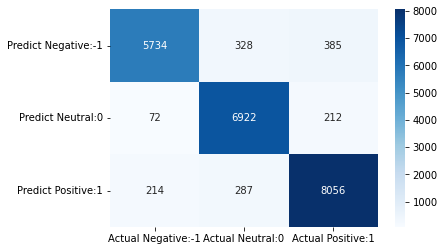

In [39]:
sns.heatmap(conf_df_svm, annot = True, fmt = '', cmap = 'Blues')

# Conclusion ML models

As expected, Naive Bayes was the model with the worst performances.
Regarding the other metrics, precision, recall and f1-score, SVM and Random Forest performed better than LR.

# Deep learning

Partiamo dall' inizio, prendiamo i dati e rifacciamo lo splitting del dataset dopo averli tokenizzati.
Per semplicità (dobbiamo creare un vocabolario quindi dobbiamo tokenizzare train e test insieme)

In [40]:
X = data['text_cleaned']
y = data['labels'].values

In [41]:
print(X[0])
print(y[0])
print(y)

two recent articl discuss h5n1 bird flu detail first delin accur 8month old project
1
[ 1 -1  0 ...  1 -1  1]


In [42]:
from collections import Counter

def Tokenize(column, seq_len):
    
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus) #Counter method counts all the words in the corpus, dictionary with word and number of times 
    sorted_words = count_words.most_common()  #list
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}  #Transform the words into numbers enumerating: first word is the one that occurs most time. 

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
        
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [43]:
vocabulary, tokenized_column = Tokenize(X, max_len)

In [44]:
vocabulary[:15]

[('covid', 35279),
 ('vaccin', 28336),
 ('pandem', 12706),
 ('amp', 12463),
 ('peopl', 11250),
 ('new', 9653),
 ('covid19', 8928),
 ('death', 8115),
 ('increas', 6896),
 ('like', 6517),
 ('still', 6280),
 ('work', 6220),
 ('get', 6205),
 ('biden', 5662),
 ('caus', 5480)]

In [45]:
print(X[0])
print(tokenized_column[0])
print(y[0])

two recent articl discuss h5n1 bird flu detail first delin accur 8month old project
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  160  694  632  460 1065
  787  154  674  106 9741 2240 8868  329 1025]
1


In [46]:
# https://tomaxent.com/2017/11/21/A-Simple-Multi-Class-Classification-Task-Keras-and-Scikit-Learn/
# 

from keras.utils import to_categorical
one_hot_encode_y = to_categorical(y, num_classes = 3)
print(one_hot_encode_y[:10])
#print(y[:10])

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [47]:
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(tokenized_column, one_hot_encode_y, test_size=0.2, stratify=one_hot_encode_y, random_state=seed_value)
X_train_dl, X_valid_dl, y_train_dl, y_valid_dl = train_test_split(X_train_dl, y_train_dl, test_size=0.2, stratify=y_train_dl, random_state=seed_value)

In [48]:
y_train_dl

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [49]:
y_test_dl

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [50]:
y_valid_dl

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [51]:
# Parameters

input_dim = len(vocabulary)+1 # +1 is for the padding

# Hyperparameters

embedding_dim = 64
hidden_dim = 32
drop_prob = 0.3
lr = 0.05
clipnorm_value = 1.

## RNN

In [52]:
# Keras Model

from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

import tensorflow.keras.metrics

from tensorflow.keras.callbacks import ModelCheckpoint


In [53]:

model_keras_rnn = Sequential([
  Embedding(input_dim, embedding_dim),
  SimpleRNN(hidden_dim, recurrent_dropout = 0.2, dropout = 0.2),
  Dropout(drop_prob),
  Dense(3, activation="sigmoid")  # 3 outputs, since we have 3 categories
])

#opt_adam = Adam(clipnorm=1, learning_rate = 0.05)

opt_sgd = SGD(learning_rate=lr, clipnorm=clipnorm_value)

model_keras_rnn.compile(optimizer=opt_sgd, loss='categorical_crossentropy', metrics=["accuracy", "Precision", "Recall"])  #categorical (not binary)
model_keras_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          2169600   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                3104      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 2,172,803
Trainable params: 2,172,803
Non-trainable params: 0
_________________________________________________________________


### Training

In [54]:
epochs = 60
batch_size = 32

In [55]:

PATH_KERAS_RNN = 'C:\\Users\\mamai\\Desktop\\Tesi\\Code\\Models\\Keras\\RNN\\Final\\'

# Model weights are saved at the end of every epoch, if it's the best seen so far.
model_checkpoint_callback = ModelCheckpoint(
    filepath=PATH_KERAS_RNN,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model_keras_rnn.fit(x=X_train_dl, y=y_train_dl,
        batch_size=batch_size, epochs=epochs,
        validation_data=(X_valid_dl, y_valid_dl),
        callbacks=[model_checkpoint_callback])

history

Epoch 1/60
2221/2221 [==============================] - 31s 13ms/step - loss: 0.7700 - accuracy: 0.6443 - precision: 0.5468 - recall: 0.7601 - val_loss: 0.5445 - val_accuracy: 0.7740 - val_precision: 0.6641 - val_recall: 0.8641
Epoch 2/60
2221/2221 [==============================] - 29s 13ms/step - loss: 0.5011 - accuracy: 0.7959 - precision: 0.6775 - recall: 0.8763 - val_loss: 0.4150 - val_accuracy: 0.8352 - val_precision: 0.7420 - val_recall: 0.8964
Epoch 3/60
2221/2221 [==============================] - 30s 14ms/step - loss: 0.4043 - accuracy: 0.8450 - precision: 0.7158 - recall: 0.9146 - val_loss: 0.3824 - val_accuracy: 0.8493 - val_precision: 0.7760 - val_recall: 0.9066
Epoch 4/60
2221/2221 [==============================] - 33s 15ms/step - loss: 0.3452 - accuracy: 0.8715 - precision: 0.7470 - recall: 0.9327 - val_loss: 0.2952 - val_accuracy: 0.8887 - val_precision: 0.8012 - val_recall: 0.9397
Epoch 5/60
2221/2221 [==============================] - 30s 14ms/step - loss: 0.3040 - a

In [56]:
# The model weights (that are considered the best) are loaded into the model.
model_keras_rnn.load_weights(PATH_KERAS_RNN)

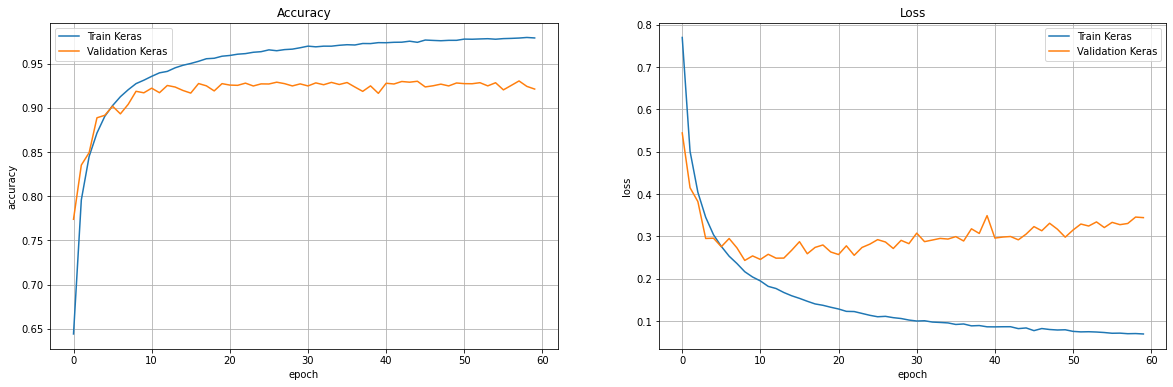

In [57]:
# Visualize results of Keras model

fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Keras')
plt.plot(history.history['val_accuracy'], label='Validation Keras')
plt.title("Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Keras')
plt.plot(history.history['val_loss'], label='Validation Keras')
plt.title("Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.show()

In [58]:
model_keras_rnn.evaluate(X_test_dl, y_test_dl, verbose=2)

695/695 - 2s - loss: 0.3433 - accuracy: 0.9301 - precision: 0.8818 - recall: 0.9520 - 2s/epoch - 3ms/step


[0.3432881236076355, 0.9301215410232544, 0.881808340549469, 0.9520035982131958]

In [59]:
y_pred = model_keras_rnn.predict(X_test_dl)

695/695 [==============================] - 2s 3ms/step


In [60]:
rnn_pred = [np.argmax(pred) for pred in y_pred]
true_pred = [np.argmax(pred) for pred in y_test_dl]

In [61]:
from sklearn.metrics import classification_report, confusion_matrix

print('Classification Report for Bert Base Uncased:\n',classification_report(true_pred, rnn_pred))

Classification Report for Bert Base Uncased:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      7206
           1       0.93      0.93      0.93      8557
           2       0.94      0.90      0.92      6447

    accuracy                           0.93     22210
   macro avg       0.93      0.93      0.93     22210
weighted avg       0.93      0.93      0.93     22210



In [62]:
conf_bert = confusion_matrix(true_pred, rnn_pred)
print(conf_bert)


[[6915  178  113]
 [ 332 7954  271]
 [ 248  410 5789]]


In [63]:
conf_df_rnn = pd.DataFrame(data=conf_bert, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'], 
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

<AxesSubplot:>

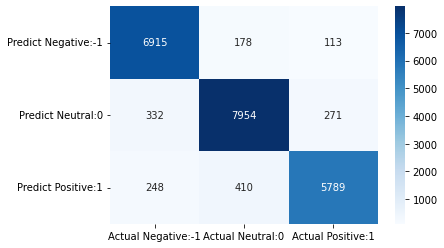

In [64]:
import seaborn as sns

sns.heatmap(conf_df_rnn, annot = True, fmt = '', cmap = 'Blues')

## LSTM

In [65]:
# Hyperparameters
batch_size=32
epochs=60

embedding_dim = 64
hidden_dim = 32
drop_prob = 0.3
lr = 0.05
clipnorm_value = 1.

In [66]:
from tensorflow.keras.layers import Bidirectional, LSTM

model_keras_lstm = Sequential([
  Embedding(input_dim, embedding_dim),
  LSTM(hidden_dim, recurrent_dropout = 0.2, dropout = 0.2),   
  Dropout(drop_prob),
  Dense(3, activation="sigmoid")
])

#opt_adam = Adam(clipnorm=1, learning_rate = 0.05)

opt_sgd = SGD(learning_rate=lr, clipnorm=clipnorm_value)

model_keras_lstm.compile(optimizer=opt_sgd, loss='categorical_crossentropy', metrics=["accuracy", "Precision", "Recall" ])
model_keras_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          2169600   
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,182,115
Trainable params: 2,182,115
Non-trainable params: 0
_________________________________________________________________


In [67]:
PATH_KERAS_LSTM = 'C:\\Users\\mamai\\Desktop\\Tesi\\Code\\Models\\Keras\\LSTM\\Simplified_Train60Test40Valid20\\'

# Model weights are saved at the end of every epoch, if it's the best seen so far.
model_checkpoint_callback = ModelCheckpoint(
    filepath=PATH_KERAS_LSTM,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model_keras_lstm.fit(x=X_train_dl, y=y_train_dl,
        batch_size=batch_size, epochs=epochs,
        validation_data=(X_valid_dl, y_valid_dl),
        callbacks=[model_checkpoint_callback])

history

Epoch 1/60
2221/2221 [==============================] - 79s 34ms/step - loss: 0.9572 - accuracy: 0.5232 - precision: 0.4741 - recall: 0.6347 - val_loss: 0.6381 - val_accuracy: 0.7306 - val_precision: 0.6300 - val_recall: 0.8464
Epoch 2/60
2221/2221 [==============================] - 81s 37ms/step - loss: 0.5140 - accuracy: 0.7949 - precision: 0.6831 - recall: 0.8767 - val_loss: 0.3908 - val_accuracy: 0.8496 - val_precision: 0.7580 - val_recall: 0.9082
Epoch 3/60
2221/2221 [==============================] - 96s 43ms/step - loss: 0.3587 - accuracy: 0.8674 - precision: 0.7564 - recall: 0.9254 - val_loss: 0.3120 - val_accuracy: 0.8841 - val_precision: 0.7982 - val_recall: 0.9305
Epoch 4/60
2221/2221 [==============================] - 85s 38ms/step - loss: 0.2888 - accuracy: 0.8977 - precision: 0.7903 - recall: 0.9446 - val_loss: 0.2929 - val_accuracy: 0.8916 - val_precision: 0.8209 - val_recall: 0.9373
Epoch 5/60
2221/2221 [==============================] - 97s 44ms/step - loss: 0.2497 - a

In [68]:
# The model weights (that are considered the best) are loaded into the model.
# The best model is the one that achieves the smaller loss on the validation set.
model_keras_lstm.load_weights(PATH_KERAS_LSTM)

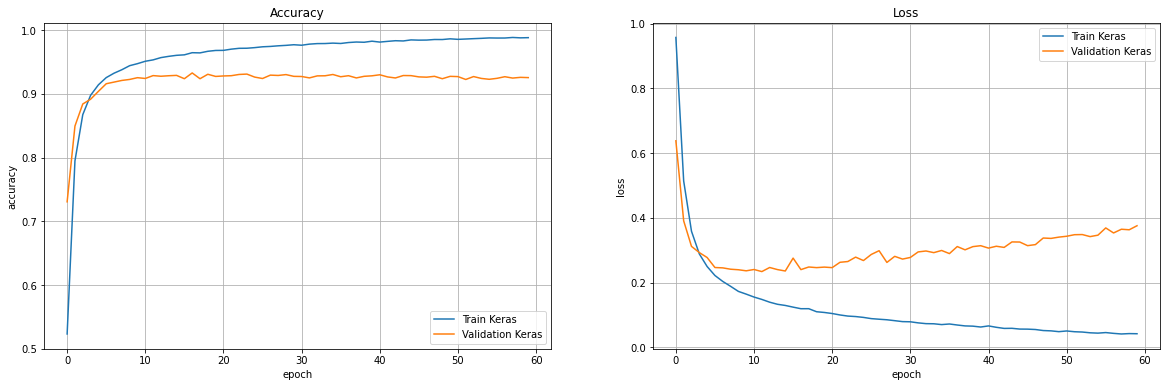

In [69]:
# Visualize results of Keras model

fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Keras')
plt.plot(history.history['val_accuracy'], label='Validation Keras')
plt.title("Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Keras')
plt.plot(history.history['val_loss'], label='Validation Keras')
plt.title("Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.show()

In [70]:
model_keras_lstm.evaluate(X_test_dl, y_test_dl, verbose=2)

695/695 - 3s - loss: 0.2502 - accuracy: 0.9296 - precision: 0.8757 - recall: 0.9538 - 3s/epoch - 5ms/step


[0.25022178888320923,
 0.9295812845230103,
 0.8756664991378784,
 0.9538496136665344]

In [71]:
y_pred = model_keras_lstm.predict(X_test_dl)

695/695 [==============================] - 4s 5ms/step


In [72]:
lstm_pred = [np.argmax(pred) for pred in y_pred]
true_pred = [np.argmax(pred) for pred in y_test_dl]

In [73]:
from sklearn.metrics import classification_report, confusion_matrix

print('Classification Report for Bert Base Uncased:\n',classification_report(true_pred, lstm_pred))

Classification Report for Bert Base Uncased:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      7206
           1       0.94      0.93      0.93      8557
           2       0.91      0.92      0.92      6447

    accuracy                           0.93     22210
   macro avg       0.93      0.93      0.93     22210
weighted avg       0.93      0.93      0.93     22210



In [74]:
conf_bert = confusion_matrix(true_pred, lstm_pred)
print(conf_bert)


[[6738  247  221]
 [ 246 7955  356]
 [ 191  303 5953]]


In [75]:
conf_df_rnn = pd.DataFrame(data=conf_bert, columns=['Actual Negative:-1', 'Actual Neutral:0', 'Actual Positive:1'], 
                                 index=['Predict Negative:-1', 'Predict Neutral:0', 'Predict Positive:1'])

<AxesSubplot:>

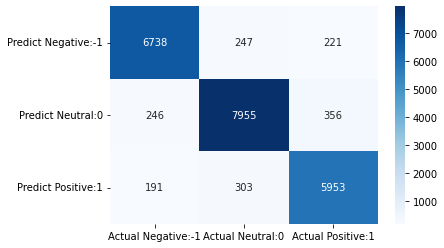

In [76]:
import seaborn as sns

sns.heatmap(conf_df_rnn, annot = True, fmt = '', cmap = 'Blues')

# Conclusion Neural Networks


0.3519522547721863, 0.92118239402771, 0.8563084602355957, 0.9505391716957092